In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from IPython.display import clear_output

/root/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Импортируем датасет CIFAR-10

In [2]:
train_dataset = datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)



Files already downloaded and verified
Files already downloaded and verified


## Визуализируем данные

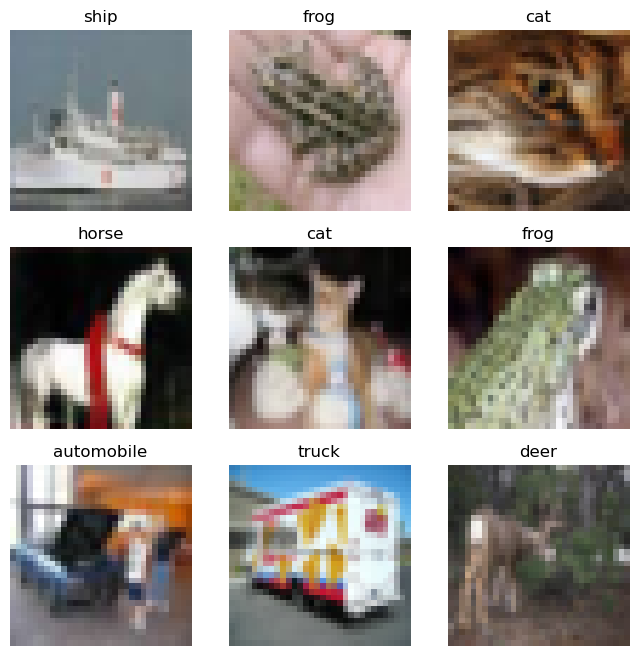

In [3]:
label_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(cols, rows, i)
    plt.title(label_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()

## Создаем DataLoaders

Feature batch size: torch.Size([64, 3, 32, 32])
Labels batch size: torch.Size([64])


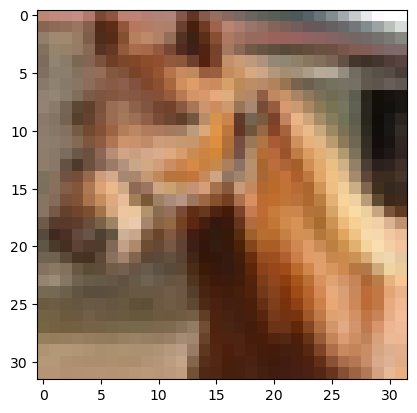

Label: horse


In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# display random image with label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch size: {train_features.size()}")
print(f"Labels batch size: {train_labels.size()}")
img = train_features[0].squeeze().permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.show()
print(f"Label: {label_map[label]}")

## Создаем модель

In [5]:
from torch import nn

In [35]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32 * 32 * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [36]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Подготовка к обучению

#### Оценка точности

In [37]:
class AverageMeters(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.cnt = 0
        self.sum = 0
        self.val = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

In [51]:
def accurasy(pred, target, topk=(1,)):
    batch_size = target.size(0)
    correct = (pred.argmax(1) == target).type(torch.float).sum().item()

    res = []
    res.append(correct * (100 / batch_size))

    return res

In [58]:
def train_loop(dataloader, model, criterion, optimizer):
    losses = AverageMeters()
    accs = AverageMeters()

    # switch to train mode
    model.train()

    for _, (data, target) in enumerate(dataloader):
        
        # compute output
        pred = model(data)
        loss = criterion(pred, target)

        # measure accurasy
        acc = accurasy(pred, target)

        # record loss and accurasy
        losses.update(loss.item(), data.size(0))
        accs.update(acc[0], data.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return accs.avg, losses.avg

In [60]:
def test_loop(dataloader, model, criterion):
    losses = AverageMeters()
    accs = AverageMeters()

    # switch to val mode
    model.eval()

    for _, (data, target) in enumerate(dataloader):

        # compute output
        pred = model(data)
        loss = criterion(pred, target)

        # measure accurasy
        acc = accurasy(pred, target)

        # record loss and accurasy
        losses.update(loss.item(), data.size(0))
        accs.update(acc[0], data.size(0))

    return accs.avg, losses.avg

## Обучение

#### Инициализируем конфиги для обучения

In [61]:
config = {
    "batch_size": 64,
    "learning_rate": 1e-3,
    "total_epochs": 16
}

#### Инициализируем начальные состояния

In [62]:
random_seed = 42

#### Инициализируем остальные параметры

In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = config["learning_rate"])

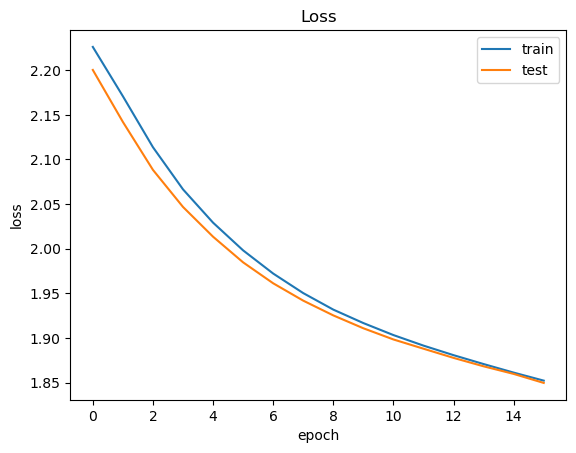

Stop train


In [66]:
print("Start train")
log = {"epoch": [], "train_acc": [], "train_loss": [], "test_acc": [], "test_loss": []}

for epoch in range(config["total_epochs"]):
    train_acc, train_loss = train_loop(train_dataloader, model, criterion, optimizer)
    test_acc, test_loss = test_loop(test_dataloader, model, criterion)

    log["epoch"].append(epoch)
    log["train_loss"].append(train_loss)
    log["test_loss"].append(test_loss)

    clear_output(wait=True)

    plt.plot(log["epoch"], log["train_loss"], label="train")
    plt.plot(log["epoch"], log["test_loss"], label="test")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss")
    plt.show()

print("Stop train")
    
    